In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import numpy as np 
import matplotlib.pyplot as plt 
import pandas 
import pydicom 
import os
from pydicom.data import get_testdata_file
import tensorflow_io as tfio

c:\Users\yunfe\anaconda3\envs\tensorflowenv\lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: '"1.2.840.10008.5.1.4.1.1.77.1.4"'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


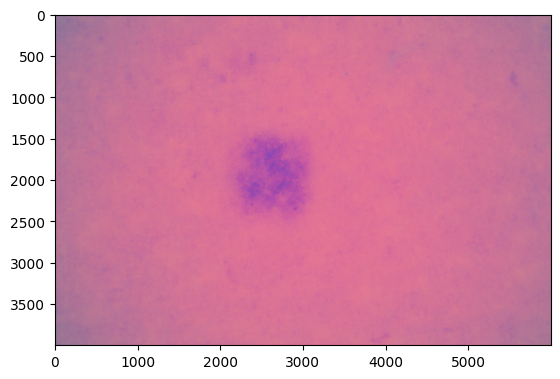

In [2]:
# READING A SIMPLE DICOM FILE
file = get_testdata_file("../test/ISC_0052060.dcm")
dicom_img = pydicom.dcmread(r"C:\Users\yunfe\Downloads\ISIC_2020_Training_Dicom\train\ISIC_3626079.dcm")
img_array = dicom_img.pixel_array
plt.imshow(img_array)

Read all training data and resize the images to 256 x 256

In [7]:
directory = r"C:\Users\yunfe\Downloads\ISIC_2020_Training_Dicom\train"

file_paths = []

for file in os.listdir(directory):
    if file.endswith(".dcm"):
        file_paths.append(os.path.join(directory, file))
    else:
        continue

metadata_df = pandas.read_csv(r"c:\Users\yunfe\Downloads\ISIC_2020_Training_Dicom\train.csv")
sample_data = metadata_df.loc[metadata_df["image_name"] == 'ISIC_3626079']
print(sample_data['age_approx'].values[0])

def preprocess_data(file_path_tensor):
    def _preprocess_single_file(file_path):
        file_path_str = file_path.numpy().decode()  # Convert tensor to string
        image = tf.io.read_file(file_path_str)
        image = tfio.image.decode_dicom_image(image, dtype=tf.float32)

        # Resize the image to 256x256
        resized_image = tf.image.resize(image, [256, 256])

        # Get metadata from CSV based on file name
        file_name = os.path.basename(file_path_str)
        metadata = metadata_df.loc[metadata_df['image_name'] == file_name[:-4]]

        # Extract label (malignant or not) from metadata
        label = metadata['target'].values[0]  # Assuming 'malignant' column contains labels
        
        return resized_image, label

    # Apply the preprocess function to each element of the tensor
    return tf.py_function(_preprocess_single_file, [file_path_tensor], (tf.float32, tf.int32))



data = tf.data.Dataset.from_tensor_slices(file_paths)
data = data.map(preprocess_data, num_parallel_calls=tf.data.experimental.AUTOTUNE)


def to_tuple(input_data, target_data):
    return (input_data, target_data)

data = data.map(to_tuple)

for s, result in data.take(2):
    print(s)
    print(result)

# # Define separate functions to extract image and label
# def extract_image_label(image, label):
#     return image

# def extract_label(image, label):
#     return label

# # Map the dataset to extract image and label separately
# images_dataset = data.map(extract_image_label)
# labels_dataset = data.map(extract_label)

40.0
tf.Tensor(
[[[[147.4668    84.44336   52.367188]
   [159.59375  103.28125   77.03125 ]
   [158.1875    98.9375    74.625   ]
   ...
   [176.31055  129.18555   98.56055 ]
   [173.625    126.3125   109.0625  ]
   [175.25     127.92383  112.78125 ]]

  [[158.11523   98.14258   72.58008 ]
   [158.69727  103.697266  73.697266]
   [155.1875    94.1875    65.28125 ]
   ...
   [174.96875  126.96875  104.875   ]
   [170.38477  123.384766  93.384766]
   [170.71875  124.15625   93.5     ]]

  [[157.6582   104.6582    73.43945 ]
   [161.50586  102.84961   67.625   ]
   [157.01953  101.01953   76.01953 ]
   ...
   [174.60352  127.603516 101.603516]
   [166.02539  110.02539   75.02539 ]
   [169.21875  118.34375   86.4375  ]]

  ...

  [[123.4375    72.21875   51.21875 ]
   [125.125     78.125     59.4375  ]
   [134.16602   92.166016  68.166016]
   ...
   [157.47852  115.478516 100.603516]
   [156.06836  120.06836  106.45508 ]
   [162.90625  119.21875   97.53516 ]]

  [[125.375     79.8125    55

Create the model

In [8]:
# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)  # Adjust output shape based on your task
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

train the model

In [10]:
print(data)
model.fit(data, epochs=10)

<MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None))>
Epoch 1/10


TypeError: 'NoneType' object is not callable